Informasi Dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   v.id           1000 non-null   int64  
 1   on road old    1000 non-null   int64  
 2   on road now    1000 non-null   int64  
 3   years          1000 non-null   int64  
 4   km             1000 non-null   int64  
 5   rating         1000 non-null   int64  
 6   condition      1000 non-null   int64  
 7   economy        1000 non-null   int64  
 8   top speed      1000 non-null   int64  
 9   hp             1000 non-null   int64  
 10  torque         1000 non-null   int64  
 11  current price  1000 non-null   float64
dtypes: float64(1), int64(11)
memory usage: 93.9 KB
None

Sampel Dataset:
   v.id  on road old  on road now  years      km  rating  condition  economy  \
0     1       535651       798186      3   78945       1          2       14   
1     2       591911     

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 

--- HASIL EVALUASI ---

Matriks Evaluasi untuk model PyTorch:
Root Mean Squared Error (RMSE): 26312.54
Mean Squared Error (MSE): 692349958.59
R-squared (R²): 0.9554

Matriks Evaluasi untuk model TensorFlow:
Root Mean Squared Error (RMSE): 28951.71
Mean Squared Error (MSE): 838201444.94
R-squared (R²): 0.9459


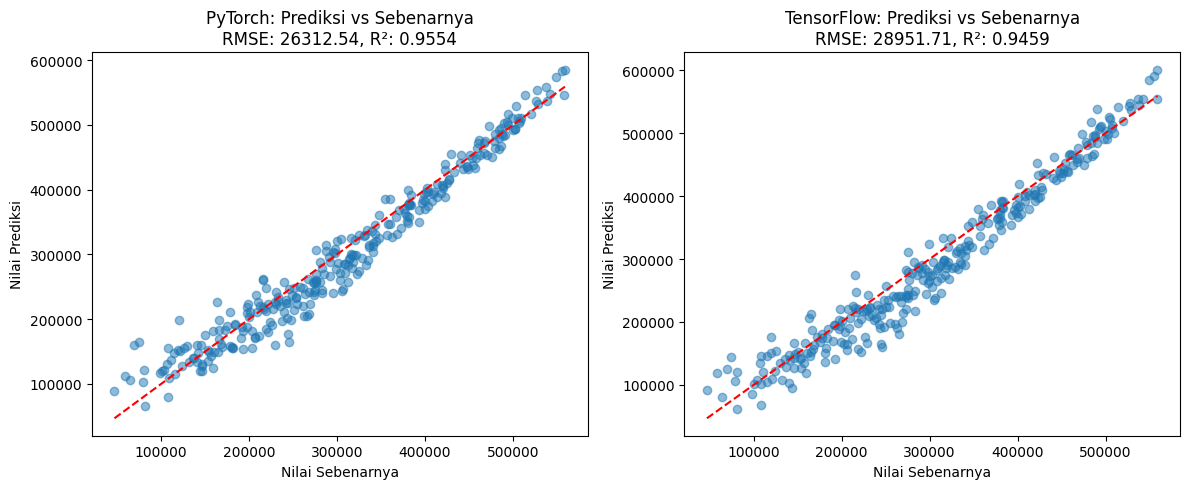

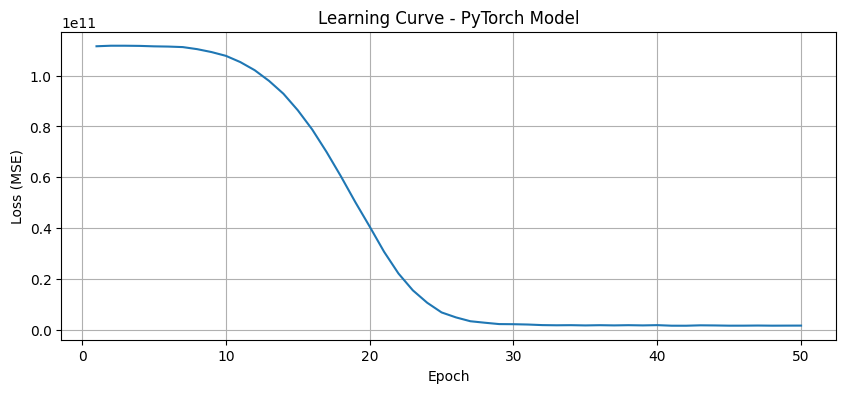

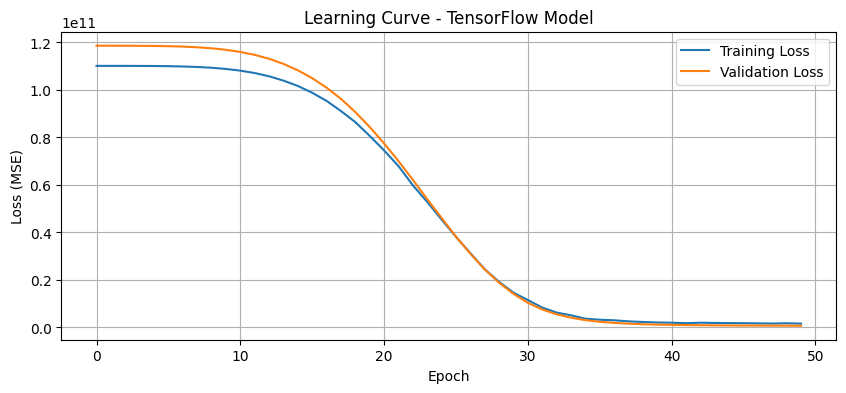


Perbandingan Metrik:
  Metrik       PyTorch    TensorFlow
0   RMSE  2.631254e+04  2.895171e+04
1    MSE  6.923500e+08  8.382014e+08
2     R²  9.553530e-01  9.459476e-01


In [2]:
# Import library yang diperlukan
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
import math

# Import library PyTorch dan TensorFlow
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam

# 1. PERSIAPAN DATA

# Baca dataset
url = "https://raw.githubusercontent.com/farrelrassya/teachingMLDL/main/02.%20Deep%20Learning/Dataset/secondhanddataset.csv"
df = pd.read_csv(url)

# Tampilkan informasi dataset
print("Informasi Dataset:")
print(df.info())
print("\nSampel Dataset:")
print(df.head())
print("\nNama-nama kolom dataset:")
print(df.columns.tolist())
print("\nStatistik Deskriptif:")
print(df.describe())

# Periksa nilai yang hilang
print("\nJumlah nilai yang hilang pada setiap kolom:")
print(df.isnull().sum())

# Identifikasi kolom target (harga) - mengasumsikan kolom terakhir adalah harga
# Kita akan memeriksa nama kolom yang mungkin berhubungan dengan harga
price_column = None
possible_price_columns = ['price', 'Price', 'PRICE', 'harga', 'Harga', 'HARGA', 'value', 'Value']

for col in possible_price_columns:
    if col in df.columns:
        price_column = col
        break

# Jika tidak ada nama kolom yang cocok, gunakan kolom terakhir
if price_column is None:
    price_column = df.columns[-1]
    print(f"\nMenggunakan kolom terakhir sebagai target: '{price_column}'")
else:
    print(f"\nMenggunakan kolom '{price_column}' sebagai target")

# Pisahkan fitur dan target
X = df.drop(price_column, axis=1)  # Semua kolom kecuali kolom harga sebagai fitur
y = df[price_column]  # Kolom harga sebagai target

# Preprocessing: Standard Scaling untuk normalisasi data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Bagi data menjadi data latih dan data uji (70:30)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)

# 2. MODEL MLP DENGAN PYTORCH

class MLPPyTorch(nn.Module):
    def __init__(self, input_size):
        super(MLPPyTorch, self).__init__()
        # Arsitektur MLP dengan 3 hidden layer
        self.layers = nn.Sequential(
            nn.Linear(input_size, 128),  # Input layer -> Hidden layer 1
            nn.ReLU(),                   # Fungsi aktivasi ReLU
            nn.Dropout(0.2),             # Dropout untuk mencegah overfitting
            nn.Linear(128, 64),          # Hidden layer 1 -> Hidden layer 2
            nn.ReLU(),                   # Fungsi aktivasi ReLU
            nn.Dropout(0.2),             # Dropout
            nn.Linear(64, 32),           # Hidden layer 2 -> Hidden layer 3
            nn.ReLU(),                   # Fungsi aktivasi ReLU
            nn.Linear(32, 1)             # Hidden layer 3 -> Output layer
        )

    def forward(self, x):
        return self.layers(x)

# Konversi data ke tensor PyTorch
X_train_tensor = torch.FloatTensor(X_train)
y_train_tensor = torch.FloatTensor(y_train.values).reshape(-1, 1)
X_test_tensor = torch.FloatTensor(X_test)
y_test_tensor = torch.FloatTensor(y_test.values).reshape(-1, 1)

# Buat dataset dan dataloader PyTorch
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(dataset=train_dataset, batch_size=32, shuffle=True)

# Inisialisasi model, loss function, dan optimizer
input_size = X_train.shape[1]
model_pytorch = MLPPyTorch(input_size)
criterion = nn.MSELoss()  # Mean Squared Error Loss
optimizer = optim.Adam(model_pytorch.parameters(), lr=0.001)

# Fungsi untuk melatih model PyTorch
def train_pytorch_model(model, train_loader, criterion, optimizer, epochs=50):
    model.train()
    losses = []

    for epoch in range(epochs):
        epoch_loss = 0
        for X_batch, y_batch in train_loader:
            # Forward pass
            y_pred = model(X_batch)
            loss = criterion(y_pred, y_batch)

            # Backward pass dan update parameter
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()

        avg_loss = epoch_loss / len(train_loader)
        losses.append(avg_loss)

        if (epoch + 1) % 10 == 0:
            print(f'Epoch [{epoch+1}/{epochs}], Loss: {avg_loss:.4f}')

    return losses

# Latih model PyTorch
print("\nMelatih Model PyTorch:")
pytorch_losses = train_pytorch_model(model_pytorch, train_loader, criterion, optimizer)

# Evaluasi model PyTorch
model_pytorch.eval()
with torch.no_grad():
    y_pred_pytorch = model_pytorch(X_test_tensor).numpy().flatten()

# 3. MODEL MLP DENGAN TENSORFLOW

# Buat model TensorFlow
def create_tensorflow_model(input_shape):
    model = Sequential([
        Dense(128, activation='relu', input_shape=(input_shape,)),
        Dropout(0.2),
        Dense(64, activation='relu'),
        Dropout(0.2),
        Dense(32, activation='relu'),
        Dense(1)
    ])

    model.compile(optimizer=Adam(learning_rate=0.001),
                 loss='mse')  # Mean Squared Error Loss

    return model

# Inisialisasi model TensorFlow
model_tensorflow = create_tensorflow_model(X_train.shape[1])

# Latih model TensorFlow
print("\nMelatih Model TensorFlow:")
history = model_tensorflow.fit(
    X_train, y_train,
    epochs=50,
    batch_size=32,
    validation_split=0.2,
    verbose=0
)

# Evaluasi model TensorFlow
y_pred_tensorflow = model_tensorflow.predict(X_test).flatten()

# 4. EVALUASI MODEL DAN MATRIKS EVALUASI

def calculate_metrics(y_true, y_pred, model_name):
    # 1. Root Mean Squared Error (RMSE)
    mse = mean_squared_error(y_true, y_pred)
    rmse = math.sqrt(mse)

    # 2. Mean Squared Error (MSE)
    # Sudah dihitung pada langkah sebelumnya

    # 3. R-squared (R²)
    r2 = r2_score(y_true, y_pred)

    print(f"\nMatriks Evaluasi untuk model {model_name}:")
    print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
    print(f"Mean Squared Error (MSE): {mse:.2f}")
    print(f"R-squared (R²): {r2:.4f}")

    return rmse, mse, r2

# Hitung metrik untuk kedua model
print("\n--- HASIL EVALUASI ---")
rmse_pytorch, mse_pytorch, r2_pytorch = calculate_metrics(y_test, y_pred_pytorch, "PyTorch")
rmse_tf, mse_tf, r2_tf = calculate_metrics(y_test, y_pred_tensorflow, "TensorFlow")

# 5. VISUALISASI HASIL

# Plot hasil prediksi vs nilai sebenarnya
plt.figure(figsize=(12, 5))

# PyTorch
plt.subplot(1, 2, 1)
plt.scatter(y_test, y_pred_pytorch, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Nilai Sebenarnya')
plt.ylabel('Nilai Prediksi')
plt.title(f'PyTorch: Prediksi vs Sebenarnya\nRMSE: {rmse_pytorch:.2f}, R²: {r2_pytorch:.4f}')

# TensorFlow
plt.subplot(1, 2, 2)
plt.scatter(y_test, y_pred_tensorflow, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Nilai Sebenarnya')
plt.ylabel('Nilai Prediksi')
plt.title(f'TensorFlow: Prediksi vs Sebenarnya\nRMSE: {rmse_tf:.2f}, R²: {r2_tf:.4f}')

plt.tight_layout()
plt.show()

# Plot learning curve untuk model PyTorch
plt.figure(figsize=(10, 4))
plt.plot(range(1, len(pytorch_losses) + 1), pytorch_losses)
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.title('Learning Curve - PyTorch Model')
plt.grid(True)
plt.show()

# Plot learning curve untuk model TensorFlow
plt.figure(figsize=(10, 4))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.title('Learning Curve - TensorFlow Model')
plt.legend()
plt.grid(True)
plt.show()

# 6. PENJELASAN PERSAMAAN MATEMATIKA

"""
PENJELASAN PERSAMAAN MATEMATIKA:

1. Mean Squared Error (MSE):
   MSE = (1/n) * Σ(y_i - ŷ_i)²

   Dimana:
   - n adalah jumlah sampel
   - y_i adalah nilai sebenarnya
   - ŷ_i adalah nilai prediksi

   MSE mengukur rata-rata kesalahan kuadrat antara nilai prediksi dan nilai sebenarnya.
   Semakin rendah nilai MSE, semakin baik model dalam memprediksi.

2. Root Mean Squared Error (RMSE):
   RMSE = √MSE = √[(1/n) * Σ(y_i - ŷ_i)²]

   RMSE adalah akar kuadrat dari MSE, yang memberikan nilai kesalahan dalam satuan yang sama dengan
   variabel target. RMSE lebih mudah diinterpretasikan karena satuannya sama dengan variabel yang diprediksi.

3. Coefficient of Determination (R²):
   R² = 1 - [Σ(y_i - ŷ_i)² / Σ(y_i - ȳ)²]

   Dimana:
   - y_i adalah nilai sebenarnya
   - ŷ_i adalah nilai prediksi
   - ȳ adalah rata-rata nilai sebenarnya

   R² mengukur proporsi variasi dalam variabel dependen yang dapat dijelaskan oleh variabel independen.
   Nilai R² berkisar antara 0 dan 1:
   - R² = 1: Model menjelaskan semua variabilitas data
   - R² = 0: Model tidak menjelaskan variabilitas data
   - R² < 0: Model lebih buruk daripada garis horizontal

4. Fungsi Aktivasi ReLU (Rectified Linear Unit):
   ReLU(x) = max(0, x)

   ReLU adalah fungsi aktivasi yang mengembalikan x jika x positif dan 0 jika x negatif.
   ReLU membantu mengatasi masalah vanishing gradient pada jaringan neural yang dalam.

5. Forward Pass dalam MLP:
   a. Input Layer: z¹ = x
   b. Hidden Layer: z^(l+1) = σ(W^l * z^l + b^l)
   c. Output Layer: ŷ = W^L * z^L + b^L

   Dimana:
   - σ adalah fungsi aktivasi (ReLU dalam kasus ini)
   - W^l adalah matriks bobot pada layer l
   - b^l adalah vektor bias pada layer l
   - z^l adalah output dari layer l
   - L adalah jumlah total layer

6. Backpropagation dengan Gradient Descent:
   W^l = W^l - η * ∂L/∂W^l
   b^l = b^l - η * ∂L/∂b^l

   Dimana:
   - η adalah learning rate
   - ∂L/∂W^l adalah gradien loss terhadap bobot
   - ∂L/∂b^l adalah gradien loss terhadap bias

7. Dropout untuk Regularisasi:
   P(z_i^l) = {
     0 dengan probabilitas p
     z_i^l/(1-p) dengan probabilitas (1-p)
   }

   Dropout secara acak menetapkan beberapa neuron menjadi 0 selama pelatihan,
   yang membantu mencegah co-adaptation dan mengurangi overfitting.
"""

# Tampilkan perbandingan metrik dari kedua model
metrics_comparison = pd.DataFrame({
    'Metrik': ['RMSE', 'MSE', 'R²'],
    'PyTorch': [rmse_pytorch, mse_pytorch, r2_pytorch],
    'TensorFlow': [rmse_tf, mse_tf, r2_tf]
})

print("\nPerbandingan Metrik:")
print(metrics_comparison)

## 1. Matriks Evaluasi

### Mean Squared Error (MSE)
MSE = (1/n) * Σ(y_i - ŷ_i)²

Dimana:
- n adalah jumlah sampel
- y_i adalah nilai sebenarnya
- ŷ_i adalah nilai prediksi

MSE mengukur rata-rata kesalahan kuadrat antara nilai prediksi dan nilai sebenarnya. Semakin rendah nilai MSE, semakin baik model dalam memprediksi.

### Root Mean Squared Error (RMSE)
RMSE = √MSE = √[(1/n) * Σ(y_i - ŷ_i)²]

RMSE adalah akar kuadrat dari MSE, yang memberikan nilai kesalahan dalam satuan yang sama dengan variabel target. RMSE lebih mudah diinterpretasikan karena satuannya sama dengan variabel yang diprediksi.

### Coefficient of Determination (R²)
R² = 1 - [Σ(y_i - ŷ_i)² / Σ(y_i - ȳ)²]

Dimana:
- y_i adalah nilai sebenarnya
- ŷ_i adalah nilai prediksi
- ȳ adalah rata-rata nilai sebenarnya

R² mengukur proporsi variasi dalam variabel dependen yang dapat dijelaskan oleh variabel independen.
Nilai R² berkisar antara 0 dan 1:
- R² = 1: Model menjelaskan semua variabilitas data
- R² = 0: Model tidak menjelaskan variabilitas data
- R² < 0: Model lebih buruk daripada garis horizontal

## 2. Penjelasan Persamaan Matematika yang Digunakan

### Fungsi Aktivasi ReLU (Rectified Linear Unit)
ReLU(x) = max(0, x)

ReLU adalah fungsi aktivasi yang mengembalikan x jika x positif dan 0 jika x negatif. ReLU membantu mengatasi masalah vanishing gradient pada jaringan neural yang dalam.

### Forward Pass dalam MLP
a. Input Layer: z¹ = x
b. Hidden Layer: z^(l+1) = σ(W^l * z^l + b^l)
c. Output Layer: ŷ = W^L * z^L + b^L

Dimana:
- σ adalah fungsi aktivasi (ReLU dalam kasus ini)
- W^l adalah matriks bobot pada layer l
- b^l adalah vektor bias pada layer l
- z^l adalah output dari layer l
- L adalah jumlah total layer

### Backpropagation dengan Gradient Descent
W^l = W^l - η * ∂L/∂W^l
b^l = b^l - η * ∂L/∂b^l

Dimana:
- η adalah learning rate
- ∂L/∂W^l adalah gradien loss terhadap bobot
- ∂L/∂b^l adalah gradien loss terhadap bias

### Dropout untuk Regularisasi
P(z_i^l) = {
  0 dengan probabilitas p
  z_i^l/(1-p) dengan probabilitas (1-p)
}

Dropout secara acak menetapkan beberapa neuron menjadi 0 selama pelatihan, yang membantu mencegah co-adaptation dan mengurangi overfitting.

## 3. Implementasi

Kedua model (PyTorch dan TensorFlow) diimplementasikan dengan arsitektur yang sama untuk memungkinkan perbandingan yang adil. Keduanya menggunakan:
- Adam optimizer dengan learning rate 0.001
- MSE sebagai fungsi loss
- Batch size 32
- 50 epoch untuk pelatihan

## 4. Proses Evaluasi

1. Dataset dibagi menjadi data latih (70%) dan data uji (30%)
2. Model dilatih pada data latih
3. Prediksi dilakukan pada data uji
4. Metrik evaluasi (RMSE, MSE, R²) dihitung berdasarkan nilai prediksi dan nilai sebenarnya
5. Hasil visualisasi berupa scatter plot dan learning curve untuk menganalisis performa model

Informasi Dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 581012 entries, 0 to 581011
Data columns (total 55 columns):
 #   Column                              Non-Null Count   Dtype
---  ------                              --------------   -----
 0   Elevation                           581012 non-null  int64
 1   Aspect                              581012 non-null  int64
 2   Slope                               581012 non-null  int64
 3   Horizontal_Distance_To_Hydrology    581012 non-null  int64
 4   Vertical_Distance_To_Hydrology      581012 non-null  int64
 5   Horizontal_Distance_To_Roadways     581012 non-null  int64
 6   Hillshade_9am                       581012 non-null  int64
 7   Hillshade_Noon                      581012 non-null  int64
 8   Hillshade_3pm                       581012 non-null  int64
 9   Horizontal_Distance_To_Fire_Points  581012 non-null  int64
 10  Wilderness_Area1                    581012 non-null  int64
 11  Soil_Type1                       

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_4 (Dense)                      │ (None, 128)                 │           7,040 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 7)                   │             231 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 17,607 (68.78 KB)

 Trainable params: 17,607 (68.78 KB)

 Non-trainable params: 0 (0.00 B)


Melatih Model TensorFlow:
Epoch 1/30
5084/5084 ━━━━━━━━━━━━━━━━━━━━ 20s 3ms/step - accuracy: 0.7007 - loss: 0.7095 - val_accuracy: 0.7664 - val_loss: 0.5279
Epoch 2/30
5084/5084 ━━━━━━━━━━━━━━━━━━━━ 18s 4ms/step - accuracy: 0.7606 - loss: 0.5520 - val_accuracy: 0.7965 - val_loss: 0.4711
Epoch 3/30
5084/5084 ━━━━━━━━━━━━━━━━━━━━ 17s 3ms/step - accuracy: 0.7798 - loss: 0.5107 - val_accuracy: 0.8090 - val_loss: 0.4453
Epoch 4/30
5084/5084 ━━━━━━━━━━━━━━━━━━━━ 17s 3ms/step - accuracy: 0.7909 - loss: 0.4873 - val_accuracy: 0.8176 - val_loss: 0.4282
Epoch 5/30
5084/5084 ━━━━━━━━━━━━━━━━━━━━ 21s 3ms/step - accuracy: 0.7993 - loss: 0.4715 - val_accuracy: 0.8270 - val_loss: 0.4111
Epoch 6/30
5084/5084 ━━━━━━━━━━━━━━━━━━━━ 21s 3ms/step - accuracy: 0.8051 - loss: 0.4604 - val_accuracy: 0.8359 - val_loss: 0.3933
Epoch 7/30
5084/5084 ━━━━━━━━━━━━━━━━━━━━ 20s 3ms/step - accuracy: 0.8089 - loss: 0.4515 - val_accuracy: 0.8392 - val_loss: 0.3874
Epoch 8/30
5084/5084 ━━━━━━━━━━━━━━━━━━━━ 18s 3ms/step -

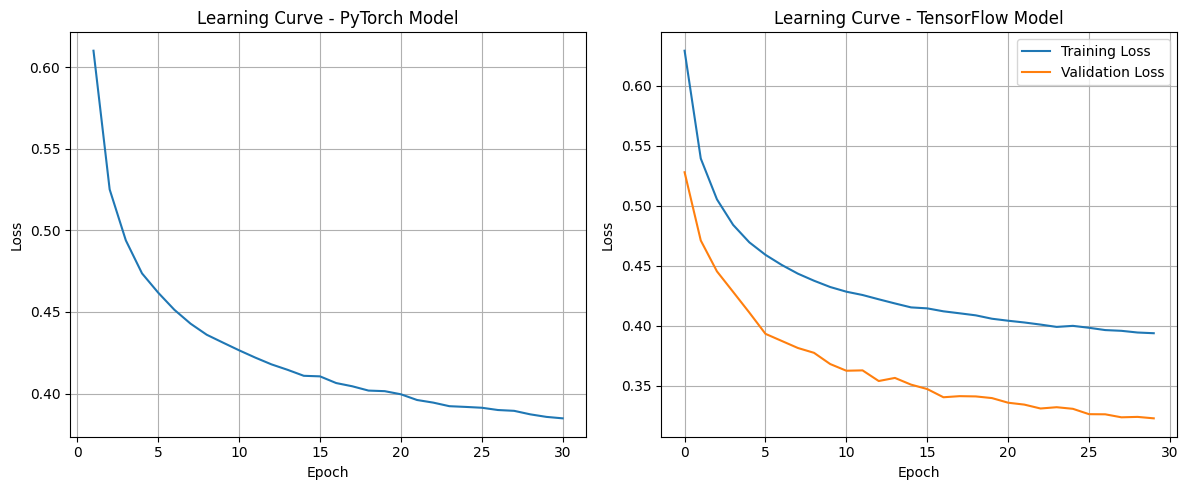

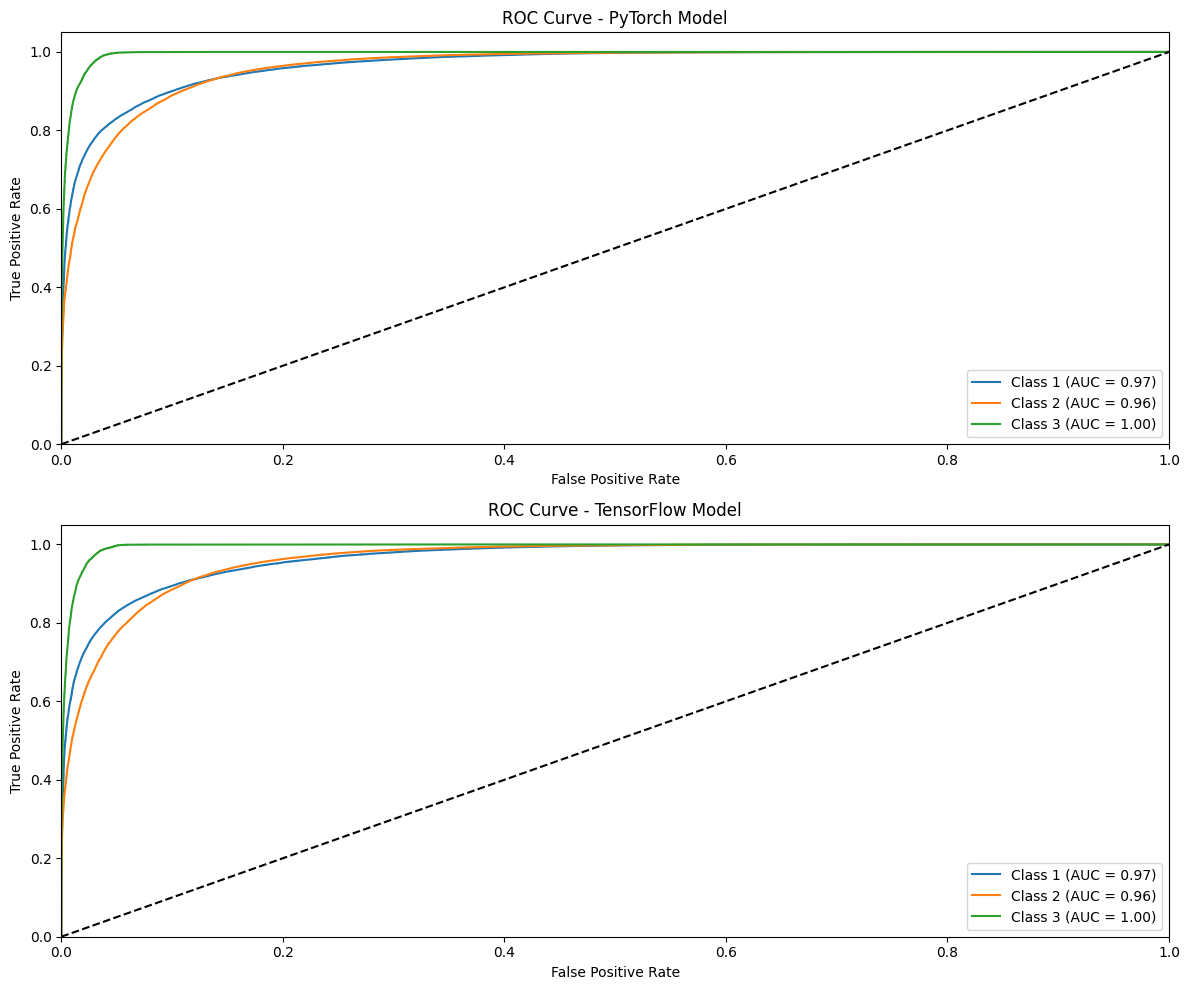

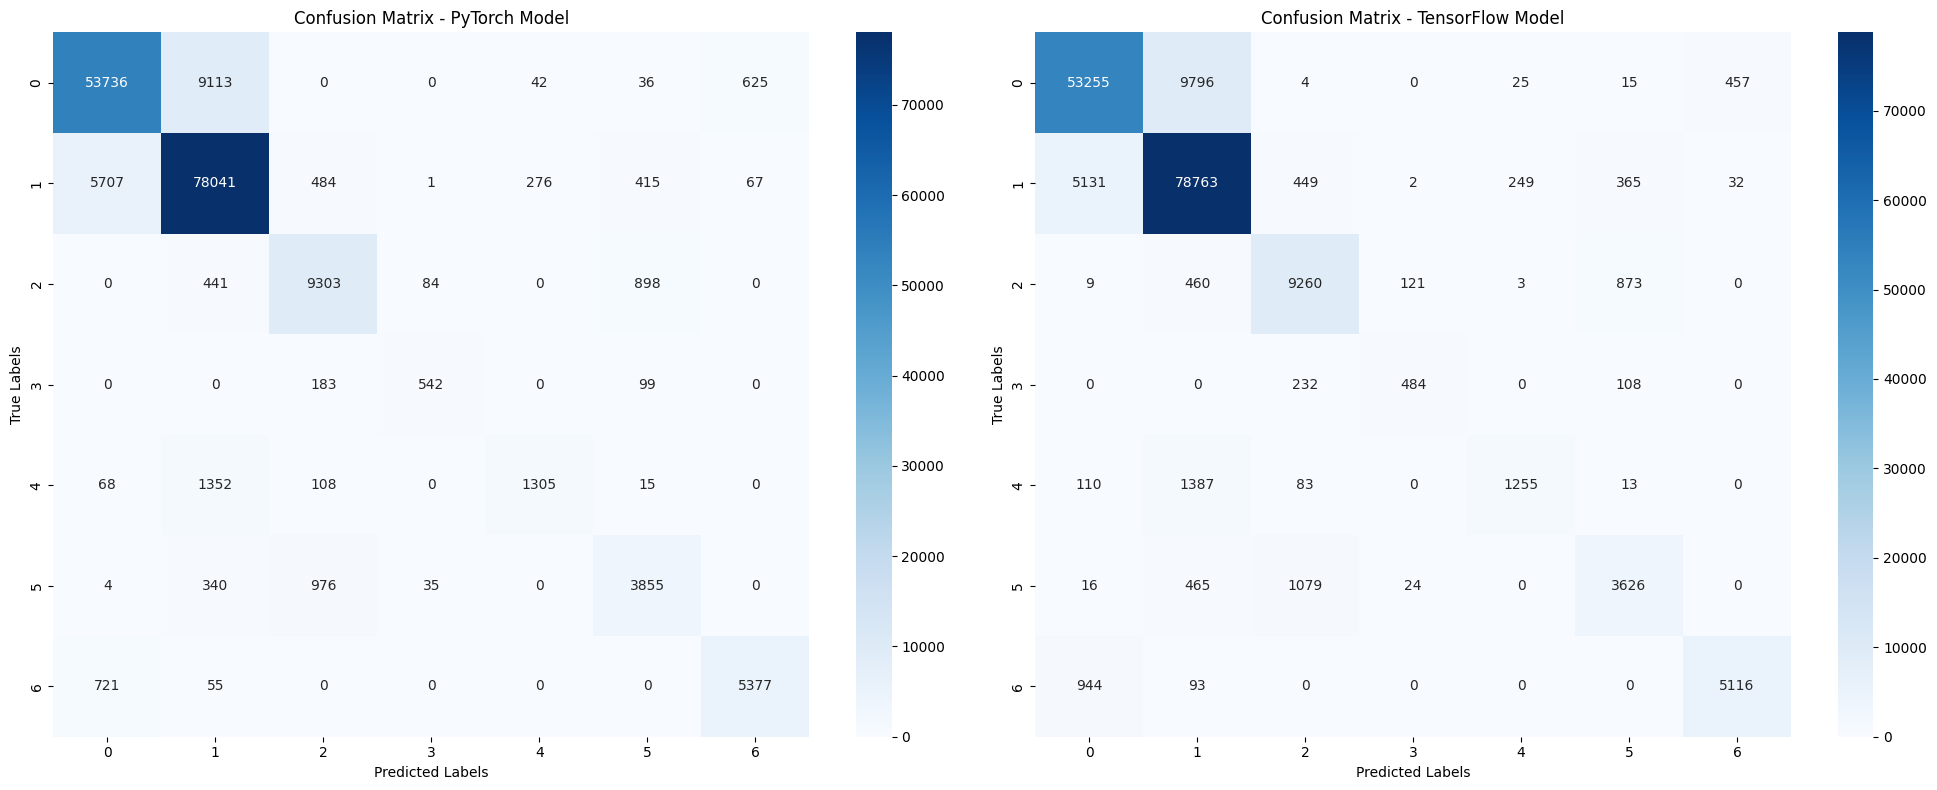


Perbandingan Metrik:
     Metrik   PyTorch  TensorFlow
0   Akurasi  0.872952    0.870657
1   Presisi  0.872925    0.870940
2    Recall  0.872952    0.870657
3  F1-Score  0.871607    0.868869
4       AUC  0.986263    0.985448


In [3]:
# Import library yang diperlukan
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import gzip
import io
import requests
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc, confusion_matrix, classification_report
import seaborn as sns

# Import library PyTorch dan TensorFlow
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical

# 1. PERSIAPAN DATA

# Baca dataset dari URL GitHub
url = "https://github.com/farrelrassya/teachingMLDL/raw/main/02.%20Deep%20Learning/Dataset/compressed_data.csv.gz"
response = requests.get(url)
with gzip.GzipFile(fileobj=io.BytesIO(response.content)) as f:
    df = pd.read_csv(f)

# Tampilkan informasi dataset
print("Informasi Dataset:")
print(df.info())
print("\nSampel Dataset:")
print(df.head())
print("\nDistribusi kelas target (Cover_Type):")
print(df['Cover_Type'].value_counts())

# Pisahkan fitur dan target
X = df.drop('Cover_Type', axis=1)
y = df['Cover_Type']

# Label encoding untuk target jika diperlukan (Pastikan target bersifat kategoris, tidak kontinu)
num_classes = len(y.unique())
print(f"\nJumlah kelas unik pada target: {num_classes}")

# Preprocessing: Standard Scaling untuk normalisasi data fitur
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Bagi data menjadi data latih dan data uji (70:30)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42, stratify=y)

print(f"Ukuran data latih: {X_train.shape}, {y_train.shape}")
print(f"Ukuran data uji: {X_test.shape}, {y_test.shape}")

# 2. MODEL MLP DENGAN PYTORCH

class MLPPyTorch(nn.Module):
    def __init__(self, input_size, num_classes):
        super(MLPPyTorch, self).__init__()
        # Arsitektur MLP dengan 3 hidden layer
        self.layers = nn.Sequential(
            nn.Linear(input_size, 128),    # Input layer -> Hidden layer 1
            nn.ReLU(),                     # Fungsi aktivasi ReLU
            nn.Dropout(0.2),               # Dropout untuk mencegah overfitting
            nn.Linear(128, 64),            # Hidden layer 1 -> Hidden layer 2
            nn.ReLU(),                     # Fungsi aktivasi ReLU
            nn.Dropout(0.2),               # Dropout
            nn.Linear(64, 32),             # Hidden layer 2 -> Hidden layer 3
            nn.ReLU(),                     # Fungsi aktivasi ReLU
            nn.Linear(32, num_classes)     # Hidden layer 3 -> Output layer
        )

    def forward(self, x):
        return self.layers(x)

# Konversi data ke tensor PyTorch
X_train_tensor = torch.FloatTensor(X_train)
y_train_tensor = torch.LongTensor(y_train.values - 1)  # Subtrak 1 jika kelas dimulai dari 1
X_test_tensor = torch.FloatTensor(X_test)
y_test_tensor = torch.LongTensor(y_test.values - 1)

# Buat dataset dan dataloader PyTorch
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)

# Inisialisasi model, loss function, dan optimizer
input_size = X_train.shape[1]
model_pytorch = MLPPyTorch(input_size, num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_pytorch.parameters(), lr=0.001)

# Fungsi untuk melatih model PyTorch
def train_pytorch_model(model, train_loader, criterion, optimizer, epochs=30):
    model.train()
    losses = []

    for epoch in range(epochs):
        epoch_loss = 0
        for X_batch, y_batch in train_loader:
            # Forward pass
            y_pred = model(X_batch)
            loss = criterion(y_pred, y_batch)

            # Backward pass dan update parameter
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()

        avg_loss = epoch_loss / len(train_loader)
        losses.append(avg_loss)

        if (epoch + 1) % 5 == 0:
            print(f'Epoch [{epoch+1}/{epochs}], Loss: {avg_loss:.4f}')

    return losses

# Latih model PyTorch
print("\nMelatih Model PyTorch:")
pytorch_losses = train_pytorch_model(model_pytorch, train_loader, criterion, optimizer)

# Evaluasi model PyTorch
model_pytorch.eval()
with torch.no_grad():
    y_pred_raw = model_pytorch(X_test_tensor)
    _, y_pred_pytorch = torch.max(y_pred_raw, 1)
    y_pred_pytorch = y_pred_pytorch.numpy()
    # Konversi probabilitas untuk ROC curve
    y_pred_proba_pytorch = torch.softmax(y_pred_raw, dim=1).numpy()

# Kembalikan prediksi ke skala asli
y_pred_pytorch_original = y_pred_pytorch + 1
y_test_original = y_test.values

# 3. MODEL MLP DENGAN TENSORFLOW

# Konversi target ke categorical untuk TensorFlow
y_train_cat = to_categorical(y_train.values - 1, num_classes=num_classes)
y_test_cat = to_categorical(y_test.values - 1, num_classes=num_classes)

# Buat model TensorFlow
def create_tensorflow_model(input_shape, num_classes):
    model = Sequential([
        Dense(128, activation='relu', input_shape=(input_shape,)),
        Dropout(0.2),
        Dense(64, activation='relu'),
        Dropout(0.2),
        Dense(32, activation='relu'),
        Dense(num_classes, activation='softmax')
    ])

    model.compile(optimizer=Adam(learning_rate=0.001),
                 loss='categorical_crossentropy',
                 metrics=['accuracy'])

    return model

# Inisialisasi model TensorFlow
model_tensorflow = create_tensorflow_model(X_train.shape[1], num_classes)

# Ringkasan model
print("\nRingkasan Model TensorFlow:")
model_tensorflow.summary()

# Latih model TensorFlow
print("\nMelatih Model TensorFlow:")
history = model_tensorflow.fit(
    X_train, y_train_cat,
    epochs=30,
    batch_size=64,
    validation_split=0.2,
    verbose=1
)

# Evaluasi model TensorFlow
y_pred_proba_tensorflow = model_tensorflow.predict(X_test)
y_pred_tensorflow = np.argmax(y_pred_proba_tensorflow, axis=1) + 1  # +1 untuk menyesuaikan kembali ke label asli

# 4. EVALUASI MODEL DAN MATRIKS EVALUASI

def calculate_metrics(y_true, y_pred, y_pred_proba, model_name):
    # Akurasi
    accuracy = accuracy_score(y_true, y_pred)

    # Presisi, Recall, dan F1-Score per kelas dan rata-rata
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')

    # Classification report
    report = classification_report(y_true, y_pred)

    # ROC Curve dan AUC untuk klasifikasi multi-kelas (One-vs-Rest)
    # Untuk multi-class, kita menggunakan pendekatan One-vs-Rest
    n_classes = len(np.unique(y_true))

    # Prepare untuk one-hot encoding y_true
    y_true_bin = np.zeros((len(y_true), n_classes))
    for i, val in enumerate(y_true):
        y_true_bin[i, val-1] = 1  # -1 karena kelas dimulai dari 1

    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_pred_proba[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Rata-rata AUC
    avg_auc = sum(roc_auc.values()) / len(roc_auc)

    print(f"\nMatriks Evaluasi untuk model {model_name}:")
    print(f"Akurasi: {accuracy:.4f}")
    print(f"Presisi (weighted): {precision:.4f}")
    print(f"Recall (weighted): {recall:.4f}")
    print(f"F1-Score (weighted): {f1:.4f}")
    print(f"AUC (rata-rata): {avg_auc:.4f}")
    print("\nClassification Report:")
    print(report)

    return accuracy, precision, recall, f1, avg_auc, fpr, tpr, roc_auc

# Hitung metrik untuk model PyTorch
print("\n--- HASIL EVALUASI MODEL PYTORCH ---")
acc_pytorch, prec_pytorch, rec_pytorch, f1_pytorch, auc_pytorch, fpr_pytorch, tpr_pytorch, roc_auc_pytorch = calculate_metrics(
    y_test_original, y_pred_pytorch_original, y_pred_proba_pytorch, "PyTorch"
)

# Hitung metrik untuk model TensorFlow
print("\n--- HASIL EVALUASI MODEL TENSORFLOW ---")
acc_tf, prec_tf, rec_tf, f1_tf, auc_tf, fpr_tf, tpr_tf, roc_auc_tf = calculate_metrics(
    y_test_original, y_pred_tensorflow, y_pred_proba_tensorflow, "TensorFlow"
)

# 5. VISUALISASI HASIL

# Plot learning curve untuk model PyTorch
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, len(pytorch_losses) + 1), pytorch_losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Learning Curve - PyTorch Model')
plt.grid(True)

# Plot learning curve untuk model TensorFlow
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Learning Curve - TensorFlow Model')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot ROC Curve untuk model PyTorch (hanya untuk satu kelas saja sebagai contoh)
plt.figure(figsize=(12, 10))

# PyTorch ROC Curve
plt.subplot(2, 1, 1)
selected_classes = min(3, num_classes)  # Ambil maksimal 3 kelas saja agar tidak terlalu padat
for i in range(selected_classes):
    plt.plot(fpr_pytorch[i], tpr_pytorch[i],
             label=f'Class {i+1} (AUC = {roc_auc_pytorch[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - PyTorch Model')
plt.legend(loc="lower right")

# TensorFlow ROC Curve
plt.subplot(2, 1, 2)
for i in range(selected_classes):
    plt.plot(fpr_tf[i], tpr_tf[i],
             label=f'Class {i+1} (AUC = {roc_auc_tf[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - TensorFlow Model')
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()

# Plot Confusion Matrix untuk kedua model
fig, axes = plt.subplots(1, 2, figsize=(20, 8))

# PyTorch Confusion Matrix
cm_pytorch = confusion_matrix(y_test_original, y_pred_pytorch_original)
sns.heatmap(cm_pytorch, annot=True, fmt="d", cmap="Blues", ax=axes[0])
axes[0].set_xlabel('Predicted Labels')
axes[0].set_ylabel('True Labels')
axes[0].set_title('Confusion Matrix - PyTorch Model')

# TensorFlow Confusion Matrix
cm_tf = confusion_matrix(y_test_original, y_pred_tensorflow)
sns.heatmap(cm_tf, annot=True, fmt="d", cmap="Blues", ax=axes[1])
axes[1].set_xlabel('Predicted Labels')
axes[1].set_ylabel('True Labels')
axes[1].set_title('Confusion Matrix - TensorFlow Model')

plt.tight_layout()
plt.show()

# 6. PERBANDINGAN METRIK UNTUK KEDUA MODEL

# Tampilkan perbandingan metrik dari kedua model
metrics_comparison = pd.DataFrame({
    'Metrik': ['Akurasi', 'Presisi', 'Recall', 'F1-Score', 'AUC'],
    'PyTorch': [acc_pytorch, prec_pytorch, rec_pytorch, f1_pytorch, auc_pytorch],
    'TensorFlow': [acc_tf, prec_tf, rec_tf, f1_tf, auc_tf]
})

print("\nPerbandingan Metrik:")
print(metrics_comparison)

# Penjelasan Matematika Model Deep Learning MLP

## Matriks Evaluasi

### 1. Akurasi (Accuracy)
**Definisi**: Proporsi prediksi yang benar dari total prediksi.

$$\text{Accuracy} = \frac{\text{Jumlah prediksi benar}}{\text{Total prediksi}} = \frac{TP + TN}{TP + TN + FP + FN}$$

Dimana:
- TP (True Positive): Kasus positif yang diprediksi benar
- TN (True Negative): Kasus negatif yang diprediksi benar
- FP (False Positive): Kasus negatif yang diprediksi sebagai positif (salah)
- FN (False Negative): Kasus positif yang diprediksi sebagai negatif (salah)

### 2. Presisi (Precision)
**Definisi**: Proporsi prediksi positif yang benar-benar positif.

$$\text{Precision} = \frac{TP}{TP + FP}$$

**Multi-kelas (weighted)**:

$$\text{Precision}_{\text{weighted}} = \sum_{i=1}^{k} w_i \times \text{Precision}_i$$

Dimana:
- $w_i$ adalah proporsi sampel kelas $i$ dari total sampel
- $k$ adalah jumlah kelas

### 3. Recall
**Definisi**: Proporsi kasus positif yang berhasil diprediksi sebagai positif.

$$\text{Recall} = \frac{TP}{TP + FN}$$

**Multi-kelas (weighted)**:

$$\text{Recall}_{\text{weighted}} = \sum_{i=1}^{k} w_i \times \text{Recall}_i$$

### 4. F1-Score
**Definisi**: Rata-rata harmonik dari presisi dan recall.

$$\text{F1-Score} = 2 \times \frac{\text{Precision} \times \text{Recall}}{\text{Precision} + \text{Recall}} = \frac{2 \times TP}{2 \times TP + FP + FN}$$

**Multi-kelas (weighted)**:

$$\text{F1}_{\text{weighted}} = \sum_{i=1}^{k} w_i \times \text{F1}_i$$

### 5. AUC (Area Under the Curve)
**Definisi**: Area di bawah kurva ROC.

$$\text{AUC} = \int_{0}^{1} TPR(FPR^{-1}(t)) \, dt$$

Dimana:
- TPR (True Positive Rate) = Recall = $\frac{TP}{TP + FN}$
- FPR (False Positive Rate) = $\frac{FP}{FP + TN}$

**Multi-kelas (one-vs-rest)**:

$$\text{AUC}_{\text{ovr}} = \frac{1}{k} \sum_{i=1}^{k} \text{AUC}_i$$

### 6. ROC (Receiver Operating Characteristic)
**Definisi**: Kurva yang menghubungkan titik-titik (FPR, TPR) pada berbagai threshold.

## Persamaan Matematika dalam Model

### 1. Fungsi Aktivasi ReLU (Rectified Linear Unit)

$$\text{ReLU}(x) = \max(0, x)$$

**Derivatif**:

$$\text{ReLU}'(x) =
\begin{cases}
1, & \text{jika } x > 0 \\
0, & \text{jika } x \leq 0
\end{cases}$$

### 2. Fungsi Aktivasi Softmax

$$\text{Softmax}(x_i) = \frac{e^{x_i}}{\sum_{j=1}^{n} e^{x_j}}$$

Dimana:
- $x_i$ adalah output dari neuron ke-$i$
- $n$ adalah jumlah neuron output (kelas)

### 3. Categorical Cross-Entropy Loss

$$\text{CCE} = -\sum_{i=1}^{n} y_i \log(\hat{y}_i)$$

Dimana:
- $y_i$ adalah nilai target sebenarnya (0 atau 1 dalam one-hot encoding)
- $\hat{y}_i$ adalah nilai prediksi (probabilitas) dari model

### 4. Forward Pass dalam MLP

**Input layer ke hidden layer pertama**:
$$z^{(1)} = W^{(1)}x + b^{(1)}$$
$$a^{(1)} = \text{ReLU}(z^{(1)})$$

**Hidden layer ke hidden layer**:
$$z^{(l)} = W^{(l)}a^{(l-1)} + b^{(l)}$$
$$a^{(l)} = \text{ReLU}(z^{(l)})$$

**Hidden layer terakhir ke output layer**:
$$z^{(L)} = W^{(L)}a^{(L-1)} + b^{(L)}$$
$$a^{(L)} = \text{Softmax}(z^{(L)})$$

Dimana:
- $x$ adalah input vektor
- $z^{(l)}$ adalah input ke layer $l$
- $a^{(l)}$ adalah output dari layer $l$ setelah aktivasi
- $W^{(l)}$ adalah matriks bobot untuk layer $l$
- $b^{(l)}$ adalah vektor bias untuk layer $l$

### 5. Backpropagation dan Gradient Descent

**Gradient Descent**:
$$w_{t+1} = w_t - \alpha \nabla_w J(w_t)$$

Dimana:
- $w_t$ adalah bobot pada iterasi $t$
- $\alpha$ adalah learning rate
- $\nabla_w J(w_t)$ adalah gradien dari fungsi cost terhadap bobot

### 6. Adam Optimizer

$$m_t = \beta_1 m_{t-1} + (1 - \beta_1) g_t$$
$$v_t = \beta_2 v_{t-1} + (1 - \beta_2) g_t^2$$
$$\hat{m}_t = \frac{m_t}{1 - \beta_1^t}$$
$$\hat{v}_t = \frac{v_t}{1 - \beta_2^t}$$
$$w_{t+1} = w_t - \alpha \frac{\hat{m}_t}{\sqrt{\hat{v}_t} + \epsilon}$$

Dimana:
- $g_t$ adalah gradien pada iterasi $t$
- $m_t$ dan $v_t$ adalah momen pertama dan kedua
- $\beta_1$ dan $\beta_2$ adalah parameter decay rates (biasanya 0.9 dan 0.999)
- $\epsilon$ adalah konstanta kecil untuk stabilitas numerik

### 7. Batch Normalization

$$\mu_B = \frac{1}{m}\sum_{i=1}^{m} x_i$$
$$\sigma_B^2 = \frac{1}{m}\sum_{i=1}^{m} (x_i - \mu_B)^2$$
$$\hat{x}_i = \frac{x_i - \mu_B}{\sqrt{\sigma_B^2 + \epsilon}}$$
$$y_i = \gamma \hat{x}_i + \beta$$

Dimana:
- $\mu_B$ adalah mean dari batch
- $\sigma_B^2$ adalah varians dari batch
- $\epsilon$ adalah konstanta kecil untuk stabilitas numerik
- $\gamma$ dan $\beta$ adalah parameter yang dipelajari

### 8. Dropout

**Training phase**:
$$r_j \sim \text{Bernoulli}(p)$$
$$\tilde{a}^{(l)} = r \odot a^{(l)}$$

**Inference phase**:
$$a^{(l)} = p \cdot a^{(l)}$$

Dimana:
- $r$ adalah vektor random mask dengan probabilitas $p$ untuk mempertahankan neuron
- $\odot$ adalah perkalian element-wise
- $\tilde{a}^{(l)}$ adalah output setelah dropout